<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
     <img style="float: right; padding-right: 10px" width="100" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
     </div>

**Clemson University**<br>
**Instructor(s):** Aaron Masino <br>

## Lab 10: Graph Neural Networks

This lab will introduce you to the creation, training, and evaluation of graph neural network models using the [PyTorch](https://pytorch.org/) and [PyTorch Lightning](https://lightning.ai/pytorch-lightning) libraries. PyTorch contains core capabilities related to the development of deep learning models. PyTorch Lightning provides functionally that abstracts much of the process of training and evaluating deep learning models created with PyTorch.

By the end of this lab, you should be able to:
- Apply PyTorch Geometric Graph Convolution modules to build graph classification models

In [1]:
# Google Colab setup
# mount the google drive - this is necessary to access supporting src
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# install any packages not found in the Colab environment
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
!pip3 install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.5 MB/s eta 0:00:00


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch import seed_everything
import lightning.pytorch.trainer as trainer
import torchmetrics as TM
import torchmetrics as TM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [9]:
def create_data_directory(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

dir_dataroot = os.path.join("..", "data")
create_data_directory(dir_dataroot)

dir_lightning = os.path.join("..", "lightning")
create_data_directory(dir_lightning)

SEED = 123456

In [10]:
# Apple MPS does not support float64, so set default tensor type to float32
if torch.backends.mps.is_available():
    torch.set_default_dtype(torch.float32)
    accelerator = "mps"
elif torch.cuda.is_available():
    accelerator = "cuda"

# Part 1 A Brief Introduction to Graph Neural Networks with PyTorch Geometric (PyG)

In [11]:
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader as PyGLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

## PyTorch Geometric (PyG) Data Representation
PyG uses the [torch_geometric.data.Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) class to represent graph data. The `Data` class is a _dictionary like_ class in that it can hold any number of arbitrarily named objects. However, some standard objects present for most graphs are the following
- __x__ : Node feature matrix (i.e., the node attributes) `[num_nodes, node_feature_dim]`
- __edge_index__ : Edges in sparse coordinate (COO) formate `[2, num_edges]`
- __edge_attr__ : Edge attritube matrix `[num_edges, edge_feature_dim]`
- __y__ : node or graph targets (i.e., class label regression value), shape depends on task

Below, we load the Mutagenicity dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) which are a collection of benchmmark datasets released by TU Dortmund University. We will have more to say about the Mutagenicity dataset below when we build our first graph classification model.

In [12]:
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

node_sum = 0
edge_sum = 0
degree_sum = 0

for data in dataset:
    node_sum += data.num_nodes
    edge_sum += data.num_edges
    degree_sum += data.num_edges / data.num_nodes

print(f'Average number of nodes: {node_sum / len(dataset):.2f}')
print(f'Average number of edges: {edge_sum / len(dataset):.2f}')
print(f'Average node degree: {degree_sum / len(dataset):.2f}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Average number of nodes: 30.32
Average number of edges: 61.54
Average node degree: 2.04

Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Batching Graphs

Although there are many graphs in our dataset, each graph is relatively small. We would like to batch these during training to maximize improve learning and maximize our GPU utilization. However, as we might expect, our graphs have variation in the number of nodes. This is similar to what we encountered in our text samples where the inputs had variable numbers of tokens. In that setting, we padded samples shorter than the maximum length sequence with `<pad>` tokens to increase their length to that of the maximum length sequence. This approach doesn't work well for graphs. Instead, we will utilize the notion of a `sparse diagonal block matrix` to _stack the adjacency matrices of the samples in our batch. Recall, that in the message passsing scheme used in graph convolutional layers, the adjacency matrix is multiplied by the weight matrix to propagate messages (i.e., node features) between neighboring nodes. For a batch of graphs, we can combine their individual adjacency matrices into a single block matrix and process it through the network. Importantly, the block matrix representation is _diagnoal_ meaning that off block entries are all zero. This prevents information from propagating between nodes of different graphs in the batch regardless of the network depth.

<img src="https://github.com/masino-teaching/CPSC-4300-6300-ADS/blob/main/images/graph-batch-pyg.png?raw=true"/>

_Block matrix representation for two graphs. (Image credit, [PyG documentation](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=mHSP6-RBOqCE))_

Fortunately, PyG handles this batching procedure for us in the [torch_geometric.loader.DataLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader) class.


### Mutagenicity Dataset
Let's look at some batches for our the Mutagenicity dataset.

Note that the dataloader provides a `DataBatch` object representing each batch. In each batch, we can immediately see that the number of samples (batch size) is 32. This is reflected also in the structure of the data where we see that the target data `y` has 32 entries.

We also see that the node feature data, `x` has been stacked into a single 2D matrix. Later, we will want to aggregate the tensors representing the nodes of an individual graph to create an overall graph representation for classification. To support this, the `DataBatch` object also includes a `batch` tensor which contains the graph index corresponding to the node index in `x` for each node. The `ptr` tensor contains a monotonically increasing list of integers that represent the node indicies corresponding to each graph, i.e., for the first graph in the batch, the nodes of that graph have indicies in `x` that span `range(ptr[0],ptr[1])`.

In [13]:
loader = PyGLoader(dataset, batch_size=32, shuffle=True)

cnt = 0
max_cnt = 3
for step, data in enumerate(loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    if cnt == 0:
        print('ptr[0]=',data['ptr'][0].item(), '\tptr[1]=',data['ptr'][1].item())
        print(f'ptr[{data.num_graphs-1}]={data["ptr"][data.num_graphs-1].item()}\t ptr[{data.num_graphs}]={data["ptr"][data.num_graphs].item()}')
        print(data['ptr'][1])
        print('edge_index[:,0]=',data['edge_index'][:,0])
        edge_index_shape = data['edge_index'].shape
        num_edges = edge_index_shape[1]
        print(f'edge_index[:,{num_edges-1}]=',data['edge_index'][:,num_edges-1])
    cnt += 1
    if cnt == max_cnt:
        break

Step 1:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 2276], x=[1197, 14], edge_attr=[2276, 3], y=[32], batch=[1197], ptr=[33])

ptr[0]= 0 	ptr[1]= 26
ptr[31]=1162	 ptr[32]=1197
tensor(26)
edge_index[:,0]= tensor([0, 1])
edge_index[:,2275]= tensor([1196, 1175])
Step 2:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 2098], x=[1022, 14], edge_attr=[2098, 3], y=[32], batch=[1022], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1892], x=[913, 14], edge_attr=[1892, 3], y=[32], batch=[913], ptr=[33])



### Data Module
As in the previous examples, we will utilize PyTorch Lightning to simplify model development. As a first step, we will create a `DataModule` to manage our training, validation, and test data splits as well has constructing our data loaders. Here, we specifically build a DataModule to handle TUDatasets.

In [14]:
class TUDataModule(L.LightningDataModule):
    def __init__(self, dataset_name, batch_size=32, test_fraction = 0.2, val_fraction = 0.1, shuffle = True,
                 class_name_map = None):
        super().__init__()
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.test_fraction = test_fraction
        self.val_fraction = val_fraction
        self.class_name_map = class_name_map
        self.num_classes = None
        self.shuffle = shuffle

    def setup(self, stage=None):
        self.dataset = TUDataset(root='data/TUDataset', name=self.dataset_name)
        self.num_classes = self.dataset.num_classes
        self.num_features = self.dataset.num_features

        test_size = int(len(self.dataset) * self.test_fraction)
        train_size = len(self.dataset) - test_size
        val_size = int(train_size * self.val_fraction)
        train_size = len(self.dataset) - test_size - val_size

        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, val_size, test_size])

        self._train_dataloader = PyGLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self._val_dataloader = PyGLoader(val_dataset, batch_size=self.batch_size,)
        self._test_dataloader = PyGLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self._train_dataloader

    def test_dataloader(self):
        return self._test_dataloader

    def val_dataloader(self):
        return self._val_dataloader


Let's make sure the DataModlue works as expected.

In [15]:
dm = TUDataModule('Mutagenicity', batch_size=32, class_name_map={0: 'Mutagenic', 1: 'Non-mutagenic'})
dm.setup()
loader = dm.train_dataloader()

cnt = 0
max_cnt = 2
for step, data in enumerate(loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    cnt += 1
    if cnt == max_cnt:
        break


Step 1:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1790], x=[874, 14], edge_attr=[1790, 3], y=[32], batch=[874], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1738], x=[844, 14], edge_attr=[1738, 3], y=[32], batch=[844], ptr=[33])



# Mutagenicity Prediction Model

Let's now build our first graph neural network. We will begin with a model that classifies an input graph representation of a molecule a mutagentic or not mutagenic. Mutagenic molecules are ones capable of cauing permanent changes in the genetic makeup of an organism, either by altering the structure of genetic material or the amount of genetic material. Such mutations may cause disease (e.g., cancer).

We saw earlier that each node in the molecule's graph representation has a 14-dimensional feature vector. This vector is a one-hot encoding of the atom represented by the node:

| Index | Atom |
|-------|------|
| 0     | C    |
| 1     | O    |
| 2     | Cl   |
| 3     | H    |
| 4     | N    |
| 5     | F    |
| 6     | Br   |
| 7     | S    |
| 8     | P    |
| 9     | I    |
| 10    | Na    |
| 11    | K    |
| 12    | Li    |
| 13    | Ca    |


## Encoder
We will adopt an enocder - output layer approach for graph classifcation. Our encoder will use graph convolutional layers. We'll create these using the PyG [conv.GCNConv class](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv). During training, the weights in these layers will be updated so as to create node representations that capture useful information about the node feature (which atom) and its realtion with its neigbors (which other atoms and in which configurations) for mutigen classificaiton. We will apply the `ReLU` activation to the output of each graph convolution layer.

We will include 2 `GCNConv` layers which will allow the representation of a given node to include information from neighbors up to 2 hops away.

In [16]:
class GCNEncoder(nn.Module):
    def __init__(self, node_feature_dim, num_hidden_layers, hidden_channels):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(GCNConv(node_feature_dim, hidden_channels))
        for i in range(num_hidden_layers - 1):
            self.hidden_layers.append(GCNConv(hidden_channels, hidden_channels))

    def forward(self, x, edge_index):
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
            x = x.relu()
        return x

# Create an instance of your encoder with 3 graph convolution layers
encoder = GCNEncoder(dm.num_features, 3, 32)

# Test the encoder
sample_batch = next(iter(dm.train_dataloader()))
print("input shape",sample_batch)
encoder_output = encoder(sample_batch.x, sample_batch.edge_index)
print("Output shape:", encoder_output.shape)

input shape DataBatch(edge_index=[2, 2000], x=[972, 14], edge_attr=[2000, 3], y=[32], batch=[972], ptr=[33])
Output shape: torch.Size([972, 32])


We are now ready to create the output module for our encoder - output model. Unlike our previous models, we need to peform an extra step before passing the encoder output to a linear layer for classification. First, we need to aggregate the node representations (i.e., embeddings) generated by the encoder to form an overall representation of the graph. This overall representation is often referred to as a __readout layer__ in the literature. Different types of readout layers are implemented in PyG in the [pooling layers module](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#pooling-layers). We will use the [torch_geometric.nn.global_mean_pool](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html#torch_geometric.nn.pool.global_mean_pool) readout layer. This method creates the representation, $R_G$ of a graph $G$ through the average latent representation of its $N$ nodes:
$$R_G = \frac{1}{N}\sum_{n=1}^{N}\bf{x}_n$$

In [17]:
class GCNOutput(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(latent_dim, num_classes)

    def forward(self, x, batch):
        # pass the encoder output through the readout layer
        x = global_mean_pool(x, batch) # batch size x latent_dim
        x = F.dropout(x, p=0.5, training=self.training) # include dropuout regularization
        x = self.linear(x) # pass through the linear layer for logits
        return x

# Test the module with random input data
gcnout = GCNOutput(32,dm.num_classes)
gcn_rslt = gcnout(encoder_output, sample_batch.batch)
print("Output shape:", gcn_rslt.shape)  # Expected output shape: [5, 10]

Output shape: torch.Size([32, 2])


With the encoder and classifier modules developed, we are now ready to create our overall classificaiton model. Following the previous practicums, we will leverage the PyTorch LightningModule class to create the model.

In [18]:
class MolecularGraphClassifierModel(L.LightningModule):
    def __init__(self, encoder, classifier, num_classes):
        super().__init__()
        # model layers
        self.encoder = encoder
        self.classifier = classifier

        # validation metrics
        self.val_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes)]), maximize=True)
        self.validation_step_outputs = []
        self.validation_step_targets = []

        # test metrics
        self.test_roc = TM.ROC(task="multiclass", num_classes=num_classes) # roc and cm have methods we want to call so store them in a variable
        self.test_cm = TM.ConfusionMatrix(task='multiclass', num_classes=num_classes)
        self.test_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes),
                                                            self.test_roc, self.test_cm]), maximize=True)
        self.test_step_outputs = []
        self.test_step_targets = []

    def forward(self, databatch):
        x = databatch.x
        edge_index = databatch.edge_index
        batch = databatch.batch
        x = self.encoder(x, edge_index)
        x = self.classifier(x, batch)
        return x

    def training_step(self, databatch, batch_idx):
        y = databatch.y
        logits = self.forward(databatch)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, databatch, batch_idx):
        y = databatch.y
        logits = self.forward(databatch)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True)

        # store the outputs and targets for the epoch end step
        self.validation_step_outputs.append(logits)
        self.validation_step_targets.append(y)
        return loss

    def on_validation_epoch_end(self):
        # stack all the outputs and targets into a single tensor
        all_preds = torch.vstack(self.validation_step_outputs)
        all_targets = torch.hstack(self.validation_step_targets)

        # compute the metrics
        loss = nn.functional.cross_entropy(all_preds, all_targets)
        self.val_metrics_tracker.increment()
        self.val_metrics_tracker.update(all_preds, all_targets)
        self.log('val_loss_epoch_end', loss)

        # clear the validation step outputs
        self.validation_step_outputs.clear()
        self.validation_step_targets.clear()

    def test_step(self, databatch, batch_idx):
        y = databatch.y
        logits = self.forward(databatch)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True)
        self.test_step_outputs.append(logits)
        self.test_step_targets.append(y)
        return loss

    def on_test_epoch_end(self):
        all_preds = torch.vstack(self.test_step_outputs)
        all_targets = torch.hstack(self.test_step_targets)

        self.test_metrics_tracker.increment()
        self.test_metrics_tracker.update(all_preds, all_targets)
        # clear the test step outputs
        self.test_step_outputs.clear()
        self.test_step_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

We can now train our model.

In [19]:
seed_everything(SEED)
dm = TUDataModule('Mutagenicity', batch_size=32, class_name_map={0: 'Mutagenic', 1: 'Non-mutagenic'})
dm.setup()

seed_everything(SEED)
encoder = GCNEncoder(dm.num_features, 3, 32)
outlayer = GCNOutput(32,dm.num_classes)
mutagenicity_model = MolecularGraphClassifierModel(encoder, outlayer, num_classes=dm.num_classes)

trainer = L.Trainer(default_root_dir=dir_lightning,
                    max_epochs=15,
                    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)])
trainer.fit(model=mutagenicity_model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

INFO: Seed set to 123456
INFO:lightning.fabric.utilities.seed:Seed set to 123456
INFO: Seed set to 123456
INFO:lightning.fabric.utilities.seed:Seed set to 123456
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


### Validation Accuracy

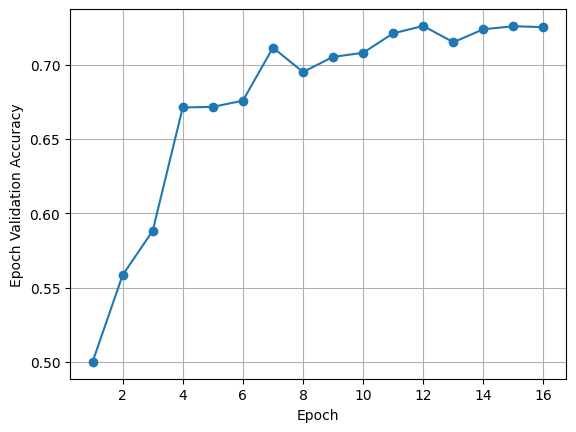

In [20]:
mca = mutagenicity_model.val_metrics_tracker.compute_all()['MulticlassAccuracy']
plt.plot(range(1, len(mca)+1), mca, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Epoch Validation Accuracy')
plt.grid()

### Test Set Performance

In [21]:
trainer.test(model=mutagenicity_model, dataloaders=dm.test_dataloader())
model = mutagenicity_model
rslt = model.test_metrics_tracker.compute()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.5371161103248596     │
└───────────────────────────┴───────────────────────────┘

               precision    recall  f1-score   support

    Mutagenic     0.7987    0.7490    0.7731       498
Non-mutagenic     0.6875    0.7453    0.7152       369

     accuracy                         0.7474       867
    macro avg     0.7431    0.7471    0.7441       867
 weighted avg     0.7514    0.7474    0.7484       867



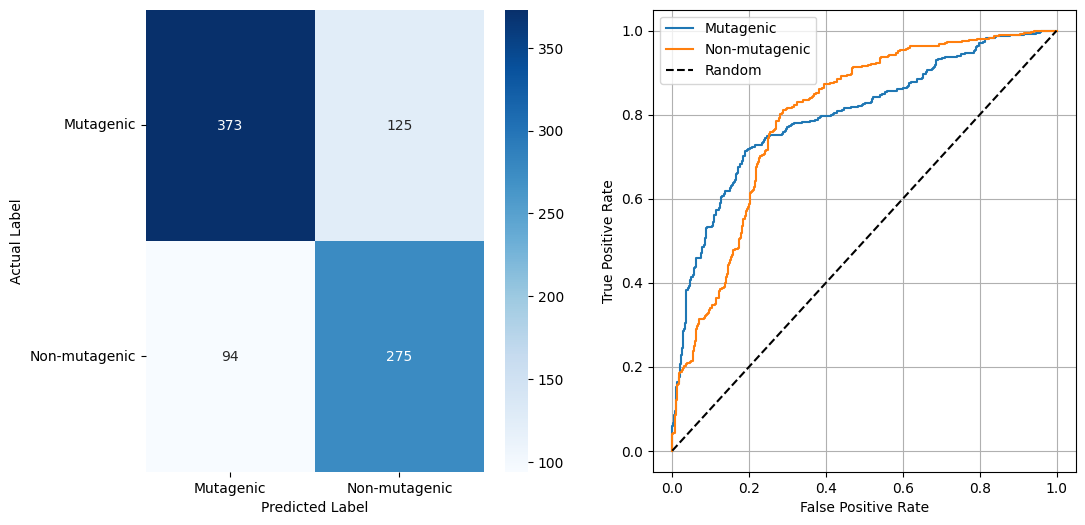

In [23]:
# Print the classification report
device = accelerator
model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for databatch in dm.test_dataloader():
        y = databatch.y
        pred = model(databatch).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(y[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=list(dm.class_name_map.values()),digits=4))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

cmp = sns.heatmap(rslt['MulticlassConfusionMatrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
cmp.set_xlabel('Predicted Label')
cmp.set_xticklabels(dm.class_name_map.values(), rotation=0)
cmp.set_yticklabels(dm.class_name_map.values(), rotation=0)
cmp.set_ylabel('Actual Label');

fpr, tpr, thresholds = rslt['MulticlassROC']
for i in range(len(dm.class_name_map)):
    axes[1].plot(fpr[i], tpr[i], label=dm.class_name_map[i])
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()